<a href="https://colab.research.google.com/github/umsh315/colab/blob/main/3D%E9%AA%A8%E6%A0%BC%E6%8E%A8%E5%AE%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
try:
  from ultralytics import YOLO
except:
  %pip install ultralytics >& /dev/null
  from ultralytics import YOLO
import cv2
import csv
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
model=YOLO(
    #'yolov8n-pose.pt'
    'yolov8s-pose.pt'
    #'yolov8m-pose.pt'
    #'yolov8l-pose.pt'
    #'yolov8x-pose.pt'
    #'yolov8x-pose-p6.pt'
)


100%|██████████| 22.4M/22.4M [00:00<00:00, 48.1MB/s]


In [11]:
import mediapipe as mp
class CFG:
  video_name='Dance2'# ここを変えることでプロジェクトを変更させる
  root_path=f'/content/drive/MyDrive/dataset/{video_name}'
  input_video_path=f'{root_path}/InputVideo.mp4'
  output_video_path=f'{root_path}/OutputVideo.mp4'
  csv_path=f'{root_path}/Output.csv'
  csv_path2=f'{root_path}/Output3d.csv'
  mp_pose = mp.solutions.pose

  # MediaPipe Pose のすべてのキーポイント名を取得
  KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

  # すべてのキーポイント間の接続を定義 (必要に応じて調整)
  connections = mp_pose.POSE_CONNECTIONS

  # キーポイント名とインデックスを対応付けた辞書を作成
  keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

cfg=CFG()

In [ ]:
!pip install yt-dlp >& /dev/null

from yt_dlp import YoutubeDL

#最高の画質と音質を動画をダウンロードする
ydl_opts = {
  'format': 'best',
  'outtmpl': cfg.input_video_path, #ここでビデオのpathを指定する。
}

#動画のURLを指定
with YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/shorts/saUSXC0NGG8?feature=share'])

[youtube] Extracting URL: https://www.youtube.com/shorts/saUSXC0NGG8?feature=share
[youtube] saUSXC0NGG8: Downloading webpage
[youtube] saUSXC0NGG8: Downloading tv client config
[youtube] saUSXC0NGG8: Downloading player e63b9241-main
[youtube] saUSXC0NGG8: Downloading tv player API JSON
[youtube] saUSXC0NGG8: Downloading ios player API JSON
[youtube] saUSXC0NGG8: Downloading m3u8 information
[info] saUSXC0NGG8: Downloading 1 format(s): 18
[download] Destination: /content/drive/MyDrive/dataset/Dance2/InputVideo.mp4
[download] 100% of  842.79KiB in 00:00:00 at 2.39MiB/s   


In [ ]:
!pip install mediapipe opencv-python

  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.26.1
    Uninstalling protobuf-5.26.1:
      Successfully uninstalled protobuf-5.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import csv

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

# 入力動画パス、出力動画パス、CSVファイルパス
input_video_path = cfg.input_video_path  # cfg.input_video_pathで定義されたパスを使用
output_video_path = cfg.output_video_path  # cfg.output_video_pathで定義されたパスを使用
csv_path2 = cfg.csv_path2  # cfg.csv_path2で定義されたパスを使用

# キーポイント名
KEYPOINTS_NAMES = cfg.KEYPOINTS_NAMES  # cfg.KEYPOINTS_NAMESで定義されたリストを使用

# 動画を読み込む
cap = cv2.VideoCapture(input_video_path)

# 出力動画の設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

# CSVファイルを開く
with open(csv_path2, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['frame'] + KEYPOINTS_NAMES * 3)  # ヘッダー行を書き込む

    # フレームごとに処理
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # BGRをRGBに変換
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Pose Estimationを実行
        results = pose.process(image)

        # 骨格情報をCSVに書き込む
        if results.pose_world_landmarks:
            row = [frame_count]
            for landmark in results.pose_world_landmarks.landmark:
                row.extend([landmark.x, landmark.y, landmark.z])
            writer.writerow(row)

        # 骨格情報を描画
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # 出力動画にフレームを書き込む
        out.write(frame)

        frame_count += 1

# キャプチャと出力動画を解放
cap.release()
out.release()

print(f'3D骨格情報を{csv_path2}に出力しました。')
print(f'骨格情報を描画した動画を{output_video_path}に出力しました。')

3D骨格情報を/content/drive/MyDrive/dataset/Dance2/Output3d.csvに出力しました。
骨格情報を描画した動画を/content/drive/MyDrive/dataset/Dance2/OutputVideo.mp4に出力しました。


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import csv

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

# 入力動画パス、出力動画パス、CSVファイルパス
input_video_path = cfg.input_video_path  # cfg.input_video_pathで定義されたパスを使用
output_video_path = cfg.output_video_path  # cfg.output_video_pathで定義されたパスを使用
csv_path2 = cfg.csv_path2  # cfg.csv_path2で定義されたパスを使用

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}


# 動画を読み込む
cap = cv2.VideoCapture(input_video_path)

# 出力動画の設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

# CSVファイルのヘッダー行を作成
header = ['frame']
for name in KEYPOINTS_NAMES:
    header.extend([f'{name}_x', f'{name}_y', f'{name}_z'])

# CSVファイルを開く
with open(csv_path2, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)  # ヘッダー行を書き込む

    # フレームごとに処理
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # BGRをRGBに変換
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Pose Estimationを実行
        results = pose.process(image)

        # 骨格情報をCSVに書き込む
        if results.pose_world_landmarks:
            row = [frame_count]
            for landmark in results.pose_world_landmarks.landmark:
                row.extend([landmark.x, landmark.y, landmark.z])
            writer.writerow(row)

        # 骨格情報を描画
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # 出力動画にフレームを書き込む
        out.write(frame)

        frame_count += 1

# キャプチャと出力動画を解放
cap.release()
out.release()

print(f'3D骨格情報を{csv_path2}に出力しました。')
print(f'骨格情報を描画した動画を{output_video_path}に出力しました。')

3D骨格情報を/content/drive/MyDrive/dataset/Dance2/Output3d.csvに出力しました。
骨格情報を描画した動画を/content/drive/MyDrive/dataset/Dance2/OutputVideo.mp4に出力しました。


In [ ]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.100 requires numpy<=2.1.1,>=1.23.0, but you have numpy 2.2.4 which is incompatible.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid.mp4に保存しました。


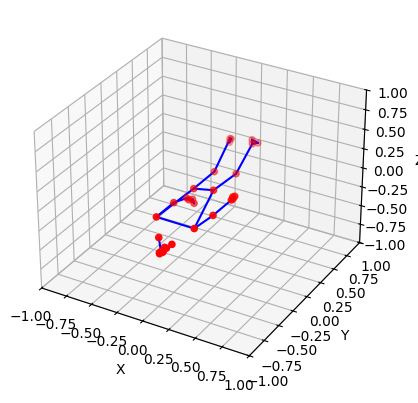

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, y, z, c='red', marker='o')

    # 接続を描画
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])  # PoseLandmarkに変換
        end_landmark = mp_pose.PoseLandmark(connection[1])  # PoseLandmarkに変換
        start_index = keypoints[start_landmark.name.lower()]  # キーポイント名でアクセス
        end_index = keypoints[end_landmark.name.lower()]  # キーポイント名でアクセス
        ax.plot([x[start_index], x[end_index]],
                [y[start_index], y[end_index]],
                [z[start_index], z[end_index]], c='blue')

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid.mp4', writer='ffmpeg')

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid.mp4に保存しました。')

<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')
<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')
<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')
<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')
<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')
<ipython-input-43-b7051eab04c5>:68: UserWarning: Glyph 12365 (\N{HIR

3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid.mp4に保存しました。


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12365 (

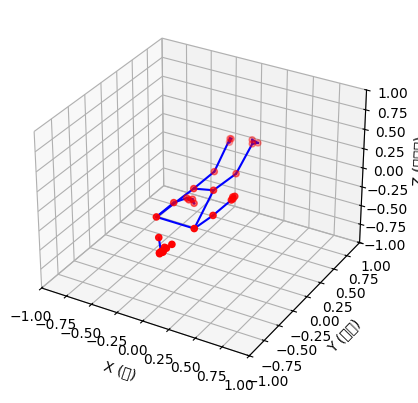

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()

    # 軸の範囲を設定 (必要に応じて調整)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # 軸ラベルを設定
    ax.set_xlabel('X (横)')  # 横軸ラベル
    ax.set_ylabel('Y (高さ)')  # 縦軸ラベル
    ax.set_zlabel('Z (奥行き)')  # 奥行き軸ラベル

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット (x, y, zの順で指定)
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, y, z, c='red', marker='o')  # x, y, zの順でプロット

    # 接続を描画 (x, y, zの順で指定)
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])
        end_landmark = mp_pose.PoseLandmark(connection[1])
        start_index = keypoints[start_landmark.name.lower()]
        end_index = keypoints[end_landmark.name.lower()]
        ax.plot([x[start_index], x[end_index]],
                [y[start_index], y[end_index]],  # yを縦軸に
                [z[start_index], z[end_index]], c='blue')  # zを奥行き軸に

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid2.mp4', writer='ffmpeg')

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid.mp4に保存しました。')

<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')
<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')
<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')
<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')
<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')
<ipython-input-44-37636aca3148>:68: UserWarning: Glyph 12373 (\N{HIR

3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid.mp4に保存しました。


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12373 (

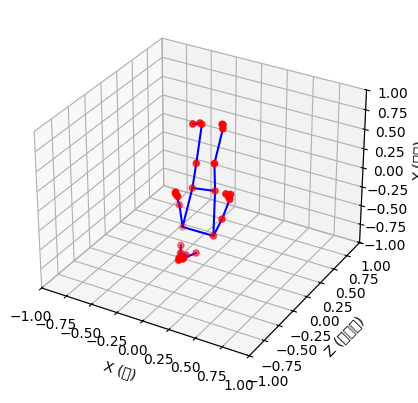

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()

    # 軸の範囲を設定 (必要に応じて調整)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # 軸ラベルを設定
    ax.set_xlabel('X (横)')  # 横軸ラベル
    ax.set_ylabel('Z (奥行き)')  # 縦軸ラベル
    ax.set_zlabel('Y (高さ)')  # 奥行き軸ラベル

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット (x, z, yの順で指定)
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, z, y, c='red', marker='o')  # x, z, yの順でプロット

    # 接続を描画 (x, z, yの順で指定)
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])
        end_landmark = mp_pose.PoseLandmark(connection[1])
        start_index = keypoints[start_landmark.name.lower()]
        end_index = keypoints[end_landmark.name.lower()]
        ax.plot([x[start_index], x[end_index]],
                [z[start_index], z[end_index]],  # zを縦軸に
                [y[start_index], y[end_index]], c='blue')  # yを奥行き軸に

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid3.mp4', writer='ffmpeg')

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid.mp4に保存しました。')

<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')
<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')
<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')
<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')
<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')
<ipython-input-45-1b83da631028>:68: UserWarning: Glyph 12373 (\N{HIR

3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid.mp4に保存しました。


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12373 (

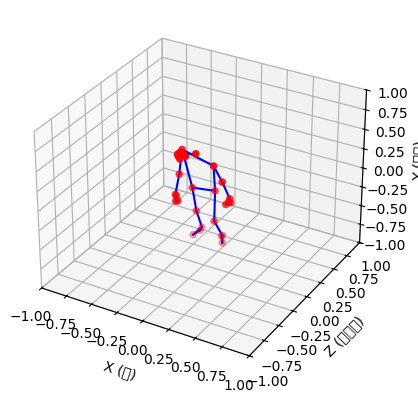

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()

    # 軸の範囲を設定 (必要に応じて調整)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # 軸ラベルを設定
    ax.set_xlabel('X (横)')  # 横軸ラベル
    ax.set_ylabel('Z (奥行き)')  # 縦軸ラベル
    ax.set_zlabel('Y (高さ)')  # 奥行き軸ラベル

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット (x, z, -yの順で指定)
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [-frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]  # -yを計算
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, z, y, c='red', marker='o')  # x, z, -yの順でプロット

    # 接続を描画 (x, z, -yの順で指定)
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])
        end_landmark = mp_pose.PoseLandmark(connection[1])
        start_index = keypoints[start_landmark.name.lower()]
        end_index = keypoints[end_landmark.name.lower()]
        ax.plot([x[start_index], x[end_index]],
                [z[start_index], z[end_index]],  # zを縦軸に
                [y[start_index], y[end_index]], c='blue')  # -yを奥行き軸に

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid4.mp4', writer='ffmpeg')

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid.mp4に保存しました。')

In [7]:
!pip install mediapipe==0.10.0

ERROR: Could not find a version that satisfies the requirement mediapipe==0.10.0 (from versions: 0.10.5, 0.10.7, 0.10.8, 0.10.9, 0.10.10, 0.10.11, 0.10.13, 0.10.14, 0.10.15, 0.10.18, 0.10.20, 0.10.21)
ERROR: No matching distribution found for mediapipe==0.10.0


In [8]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


<ipython-input-14-cc90edafcc5b>:68: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-14-cc90edafcc5b>:68: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-14-cc90edafcc5b>:68: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-14-cc90edafcc5b>:68: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-14-cc90edafcc5b>:68: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified.mp4

3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid_modified.mp4に保存しました。


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12373 (

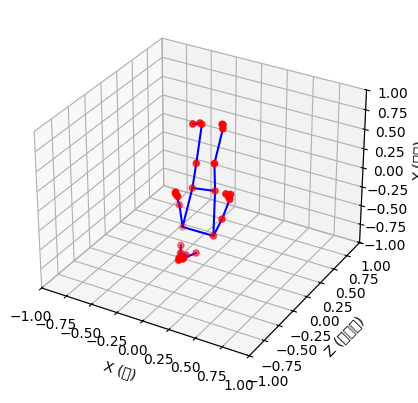

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()

    # 軸の範囲を設定 (必要に応じて調整)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # 軸ラベルを設定
    ax.set_xlabel('X (横)')  # 横軸ラベル
    ax.set_ylabel('Z (奥行き)')  # 縦軸ラベル  # 修正: Z軸を奥行きに
    ax.set_zlabel('Y (高さ)')  # 奥行き軸ラベル  # 修正: Y軸を高さに

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット (x, z, yの順で指定)
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, z, y, c='red', marker='o')  # 修正: y と z を入れ替える

    # 接続を描画 (x, z, yの順で指定)
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])
        end_landmark = mp_pose.PoseLandmark(connection[1])
        start_index = keypoints[start_landmark.name.lower()]
        end_index = keypoints[end_landmark.name.lower()]
        ax.plot([x[start_index], x[end_index]],
                [z[start_index], z[end_index]],  # 修正: y と z を入れ替える
                [y[start_index], y[end_index]], c='blue')

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid_modified.mp4', writer='ffmpeg')  # ファイル名を変更

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid_modified.mp4に保存しました。')  # ファイル名を変更

<ipython-input-36-495c0189ea05>:68: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified2.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-36-495c0189ea05>:68: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified2.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-36-495c0189ea05>:68: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified2.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-36-495c0189ea05>:68: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified2.mp4', writer='ffmpeg')  # ファイル名を変更
<ipython-input-36-495c0189ea05>:68: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  ani.save(f'{cfg.root_path}/3dgrid_modified

3D骨格情報をプロットした動画を/content/drive/MyDrive/dataset/Dance2/3dgrid_modified2.mp4に保存しました。


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12373 (

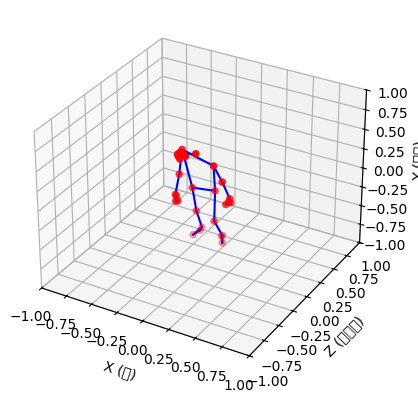

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# MediaPipe Poseの初期化
mp_pose = mp.solutions.pose

# ... (cfg オブジェクトの定義) ...

# CSVファイルを読み込む
df = pd.read_csv(cfg.csv_path2)

# プロットの設定
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# MediaPipe Pose のすべてのキーポイント名を取得
KEYPOINTS_NAMES = [landmark.name.lower() for landmark in mp_pose.PoseLandmark]

# すべてのキーポイント間の接続を定義 (必要に応じて調整)
connections = mp_pose.POSE_CONNECTIONS

# キーポイント名とインデックスを対応付けた辞書を作成
keypoints = {name: mp_pose.PoseLandmark[name.upper()].value for name in KEYPOINTS_NAMES}

# アニメーションのフレーム数
num_frames = len(df)

# アニメーション関数
def animate(i):
    ax.clear()

    # 軸の範囲を設定 (必要に応じて調整)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # 軸ラベルを設定
    ax.set_xlabel('X (横)')  # 横軸ラベル
    ax.set_ylabel('Z (奥行き)')  # 縦軸ラベル  # 修正: Z軸を奥行きに
    ax.set_zlabel('Y (高さ)')  # 奥行き軸ラベル  # 修正: Y軸を高さに

    # i番目のフレームの骨格情報を取得
    frame_data = df.iloc[i]

    # キーポイントをプロット (x, z, yの順で指定)
    x = [frame_data[f'{name}_x'] for name in KEYPOINTS_NAMES]
    y = [-frame_data[f'{name}_y'] for name in KEYPOINTS_NAMES]
    z = [frame_data[f'{name}_z'] for name in KEYPOINTS_NAMES]
    ax.scatter(x, z, y, c='red', marker='o')  # 修正: y と z を入れ替える

    # 接続を描画 (x, z, yの順で指定)
    for connection in connections:
        start_landmark = mp_pose.PoseLandmark(connection[0])
        end_landmark = mp_pose.PoseLandmark(connection[1])
        start_index = keypoints[start_landmark.name.lower()]
        end_index = keypoints[end_landmark.name.lower()]
        ax.plot([x[start_index], x[end_index]],
                [z[start_index], z[end_index]],  # 修正: y と z を入れ替える
                [y[start_index], y[end_index]], c='blue')

# アニメーションを作成
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000/30)  # 30fps

# MP4ファイルとして保存
ani.save(f'{cfg.root_path}/3dgrid_modified2.mp4', writer='ffmpeg')  # ファイル名を変更

print(f'3D骨格情報をプロットした動画を{cfg.root_path}/3dgrid_modified2.mp4に保存しました。')  # ファイル名を変更